![logo](https://github.com/donatellacea/DL_tutorials/blob/main/notebooks/figures/1128-191-max.png?raw=true)

# Model-Agnostic Interpretation with LIME for Image Analysis

In this notebook, we will demonstrate how to use the Local Interpretable Model-agnostic Explanations (LIME) method introduced in 2016 in the paper entitled "Why should I trust you?: Explaining the predictions of any classifier" by [Rubiero et. al., 2016](https://arxiv.org/abs/1602.04938).

We will focus on how to apply this method and interpret its results for image classification models.

--------

## Getting Started

### Setup Colab environment

If you installed the packages and requirements on your machine, you can skip this section and start from the import section.
Otherwise, you can follow and execute the tutorial on your browser. To start working on the notebook, click on the following button. This will open this page in the Colab environment, and you will be able to execute the code on your own.

<a href="https://colab.research.google.com/github/HelmholtzAI-Consultants-Munich/Zero2Hero---Introduction-to-XAI/blob/Juelich-2023/xai-for-image-data/Tutorial_LIME_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Now that you opened the notebook in Google Colab, follow the next step:

1. Run this cell to connect your Google Drive to Colab and install packages
2. Allow this notebook to access your Google Drive files. Click on 'Yes', and select your account.
3. "Google Drive for desktop wants to access your Google Account". Click on 'Allow'.
   
At this point, a folder has been created in your Drive, and you can navigate it through the lefthand panel in Google Colab. You might also have received an email that informs you about the access on your Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive
!git clone --branch Juelich-2023 https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials.git
%cd XAI-Tutorials/xai-for-image-data
%pip install lime

### Imports

Let's start with importing all required Python packages.

In [10]:
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
import utils
from PIL import Image as PilImage

from lime import lime_image
from skimage.segmentation import mark_boundaries

import torch
from torchvision import models, transforms
from torchvision.models.inception import Inception_V3_Weights
from torch.autograd import Variable
import torch.nn.functional as F

In [11]:
# assert reproducible random number generation
seed = 1
np.random.seed(seed)
torch.manual_seed(seed)

## Data and Model Loading

Let's use an image we have in our 'data_and_models' folder.

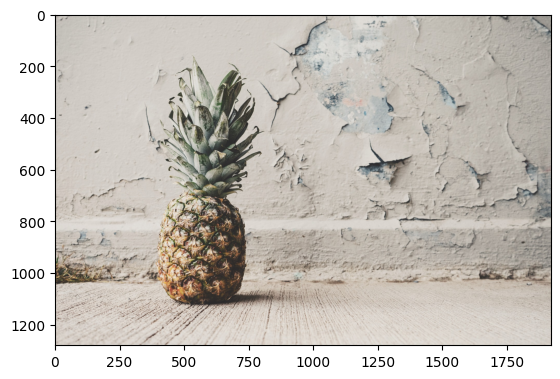

In [12]:
path_to_img = '../data_and_models/images/pineapple.jpg'

img = utils.read_image(path_to_img)
plt.imshow(img)

We start making some transformations to ensure the input data is in the correct format and optimized for model training and inference. If you want to know more about these transformations, you can check the utils.py.

In [13]:
# Resize and center crop
pill_transf = utils.get_pil_transform()

For the model, we chose the pre-trained Inception V3 architecture based on the paper "*Rethinking the Inception Architecture for Computer Vision*" ([Szegedy et al., 2015](https://arxiv.org/pdf/1512.00567.pdf)) and available in the PyTorch library.
Inception V3 improved upon its predecessor by incorporating smaller kernel size, factorized convolution, auxiliary classifier, and batch normalization to improve efficiency, reduce the computational cost, and combat the vanishing gradient problem.

In [14]:
model = models.inception_v3(weights=Inception_V3_Weights.DEFAULT)

We generate predictions on the batch of images through the ```batch_predict``` function, which returns a batch of predicted probabilities for each class. Then, we extract the index of the class with the highest probability in the flattened array, indicating the predicted class label.

In [15]:
# Make preditction
pred = utils.batch_predict([pill_transf(img)], model)
top_class = pred.squeeze().argmax()
print(f"The predicted class with the highest probability is: {top_class}")

The predicted class with the highest probability is: 953


Click [this link](https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/) to identify the class name and see if the prediction is correct.

## Now, what does my model think is important in the data?

We prepared a small [Introduction to LIME](https://xai-tutorials.readthedocs.io/en/latest/_model_agnostic_xai/lime.html) for you, to help you understand how this method works.
In summary, LIME constructs a surrogate linear regression model to approximate black-box predictions on one observation and the neighborhood of the observation.

### LIME for Images: Theoretical Summary
But let's see what this means for image classification. The paper [What Does LIME Really See in Images?](http://proceedings.mlr.press/v139/garreau21a/garreau21a.pdf) provides a detailed explanation of this method on images, but let's summarize the main concepts.

On images, LIME creates perturbations by altering regions of the image, constructs a dataset with interpretable features for a surrogate model using these perturbed images, and measures model prediction changes using a linear model to highlight the most influential regions.

**How do we create the image perturbation?**

LIME segments the image into sections known as **superpixels**, breaking it down into $d$ subregions referred to as also as **interpretable components**. By default, LIME uses the *quickshift* algorithm to produce these superpixels (Vedaldi and Soatto, 2008). You can choose a different segmentation algorithm by setting the ```segmentation_fn``` argument in the ```explain_instance``` method.
LIME introduces perturbations to these interpretable components by modifying pixel values within each superpixel region, typically turning them gray or replacing them with the mean of all pixels in the superpixel. Each perturbed instance is then fed into the model to generate new predictions for the originally predicted class. These predictions will be the labels for the new dataset. This dataset is utilized to train LIME's linear model, helping assess the contribution of each interpretable component to the original prediction.

In the picture below, we can see an example of the original image on the left and an overlay of the superpixels (yellow) in the middle. On the right, we can see some examples of perturbed images passed to the inference algorithm to make new predictions.

<div style="text-align:center;">
    <img src="https://www.oreilly.com/api/v2/epubs/9781098119126/files/assets/eaip_0424.png" width="700" height="500">
</div>

[Image source](https://www.oreilly.com/library/view/explainable-ai-for/9781098119126/ch04.html)

**How do we create the dataset for the surrogate model?**

LIME creates the dataset from the $n$ perturbed images. Indeed, for each newly generated example $x_i$, the superpixels are randomly switched on and off, and this information is encoded in a vector $z_i ∈ \{0, 1\}^d$, where each coordinate of $z_i$
corresponds to the activation ($z_{i,j} = 1$) or inactivation ($z_{i,j} = 0$) of superpixel $j$. We call the $z_i$ the **interpretable features**. 
These perturbations are just simple binary representations of the image indicating the “presence” or “absence” of each superpixel region. Since we care about the perturbations closest to the original image, those examples with the most superpixels present are weighted more than examples with more superpixels absent. This proximity can be measured using any distance metric for images.

**How do we measure the change in the model prediction?**

In the next step, LIME builds a surrogate model with the interpretable features $z_i$ as input and the predicted outcomes $y_i:= f(x_i)$ as responses, i.e., labels. The linear model is represented as:

$\hat{y}_i = \beta_0 + \beta_1 z_{i,1} + \beta_2 z_{i,2} + \ldots + \beta_d z_{i,d} + \epsilon_i$

Here, $\hat{y}_i$ is the outcome predicted by the surrogate model for the $i$-th perturbed instance, $z_{i,j}$ is the $j$-th interpretable feature, and $ϵ_i$ is the prediction error with respect to the actual label $y_i$.
In the default implementation, LIME obtains this linear model using (weighted) ridge regression. The final step involves displaying the superpixels associated with the top positive coefficients of $\beta$.

### LIME for Images: Method Implementation

To utilize LIME for image explanations, the first step is to instantiate the ```LimeImageExplainer()``` class. Subsequently, the ```explain_instance``` method is employed with the following parameters:

- ```image```: the image represented as a NumPy array.
- ```classifier_fn```: the model used for making predictions.
- ```top_labels```: the number of top classes for which explanations are generated.
- ```hide_color```: the color assigned to non-activated superpixels (set to a specific color, or 'avg' to use the mean over the superpixel region).
- ```num_samples```: the size of the neighborhood to learn the linear model.
- ```random_seed```: to ensure reproducibility in the segmentation, set the random seed for consistent results.
  
In our specific instance, explanations are generated for the top 5 classes, and the background color for non-activated superpixels is set to black.

For more details about all the possible parameters, check out the [LIME documentation](https://lime-ml.readthedocs.io/en/latest/lime.html#module-lime.lime_image).

In [16]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(image=np.array(pill_transf(img)), 
                                         classifier_fn=lambda images: utils.batch_predict(images, model), 
                                         top_labels=5, 
                                         hide_color=None, 
                                         num_samples=1000,
                                         random_seed=42) 

  0%|          | 0/1000 [00:00<?, ?it/s]

To visualize the instance explanation, the ```get_image_and_mask``` method can be utilized with the following configurable parameters:

- ```label```: the label for which the explanation is desired.
- ```positive_only```: if ```True```, considers only superpixels that positively contribute to the prediction of the label.
- ```negative_only```: if ```True```, considers only superpixels that negatively contribute to the prediction of the label. If ```False```, both negative and positive contributions are considered. Note that both cannot be ```True``` simultaneously.
- ```hide_rest```: if ```True```, renders the non-explanation part of the return image in gray.
- ```num_features```: the number of superpixels to include in the explanation.
-  ```min_weight```: minimum weight of the superpixels to include in the explanation 
   
We will show three scenarios: one where positive contributions (```positive_only```)are active, another where negative contributions (```negative_only```) are active, and a third where both are included simultaneously (both set to False).

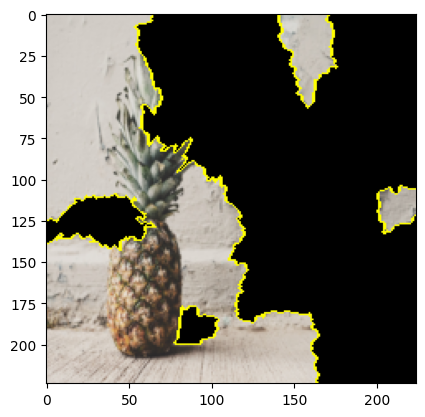

In [39]:
# Plot mask with positive contributions
label_to_explain = 0
temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[label_to_explain],
    positive_only=True,
    negative_only=False,
    num_features=10,
    hide_rest=True,
    min_weight=0,
)
normalized_temp = temp / 255.0
img_boundry1 = mark_boundaries(normalized_temp, mask)
plt.imshow(img_boundry1)

In this first example, we set ```num_features=10```, meaning that we want to extract the top 10 features (segmented areas) that contribute most to predicting the ananas. In other words, our model heavily depends on the ten segmented areas to recognize the ananas in the image. Try to change this parameter and see what happens.

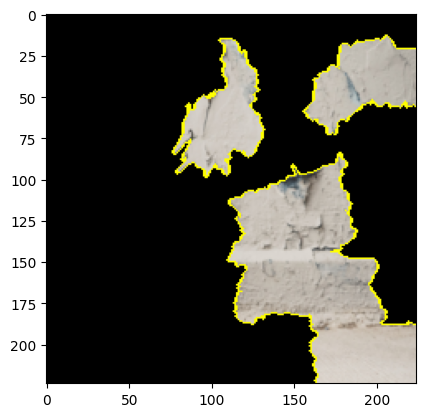

In [33]:
# Plot mask with negative contributions
temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[label_to_explain],
    positive_only=False,
    negative_only=True,
    num_features=10,
    hide_rest=True,
    min_weight=0,
)
normalized_temp = temp / 255.0
img_boundry2 = mark_boundaries(normalized_temp, mask)
plt.imshow(img_boundry2)

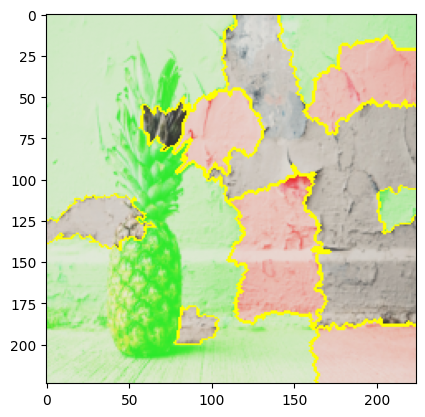

In [24]:
# Plot mask with both positive and negative contributions
temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[label_to_explain],
    positive_only=False,
    negative_only=False,
    num_features=20, # increased to show more superpixels
    hide_rest=False,
    min_weight=0,
)
normalized_temp = temp/255.0
img_boundry3 = mark_boundaries(normalized_temp, mask)
plt.imshow(img_boundry3)

### Extra

Now, let's apply the whole procedure to another image. 
In this picture, we encounter both a dog and a cat. Let's reiterate the process of conducting inference and employing LIME. 
Printing the output for the top 10 predicted classes, we notice that the leading predictions include species like lynx or various other types of cats, with the initial dog prediction appearing at the seventh. Our focus will be to compare the LIME outcomes for the first and seventh classes. This comparison aims to shed light on why the model perceives a lynx or a cat species (class 0) in the image or a dog (class 6).

In [ ]:
import json
import requests

path_to_img = '../data_and_models/images/cat_and_dog.jpg'
img = utils.read_image(path_to_img)

# Make prediction and print top-10 classes and labels
pred = utils.batch_predict([pill_transf(img)], model)

# Fetch ImageNet class labels
imagenet_classes_url = 'https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json'
response = requests.get(imagenet_classes_url)
class_labels = json.loads(response.text)

# Getting the top 10 predicted classes and their probabilities
top_10_classes = pred.squeeze().argsort()[-10:][::-1]  # Indices of top 5 classes
print("Top 10 predicted classes with their label and class names:")
for i in range(10):
    class_idx = top_10_classes[i]
    class_name = class_labels[class_idx]
    print(f"Class {i}: label {class_idx} - {class_name}")


In [77]:
# Define explainer
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(image=np.array(pill_transf(img)), 
                                         classifier_fn=lambda images: utils.batch_predict(images, model), 
                                         top_labels=10, 
                                         hide_color=None, 
                                         num_samples=1000,
                                         random_seed=42) 

  0%|          | 0/1000 [00:00<?, ?it/s]

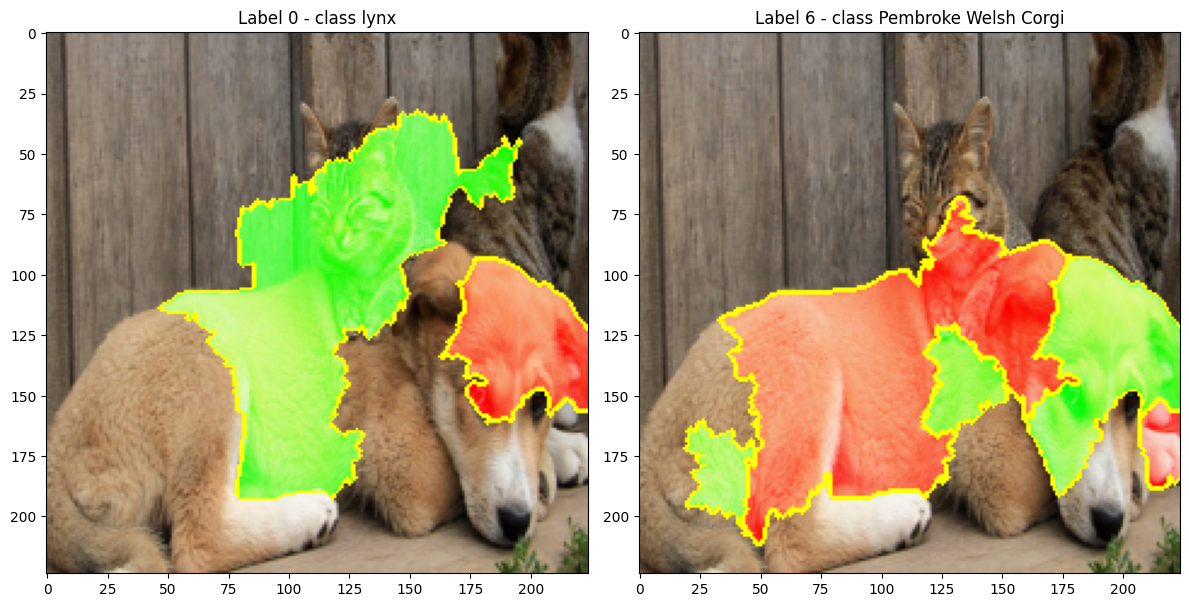

In [81]:
# Plot mask with positive contributions
label_to_explain = 0
temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[label_to_explain],
    positive_only=False,
    negative_only=False,
    num_features=5,
    hide_rest=False,
    min_weight=0,
)
normalized_temp = temp / 255.0
img_boundry0 = mark_boundaries(normalized_temp, mask)

label_to_explain = 6
temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[label_to_explain],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False,
    min_weight=0,
)
normalized_temp = temp / 255.0
img_boundry6 = mark_boundaries(normalized_temp, mask)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Creating a figure with two subplots

# Plotting the first image (label_to_explain = 0)
axes[0].imshow(img_boundry0)
axes[0].set_title(f"Label 0 - class {class_labels[287]}")

# Plotting the second image (label_to_explain = 6)
axes[1].imshow(img_boundry6)
axes[1].set_title(f"Label 6 - class {class_labels[263]}")

plt.tight_layout()  # Adjusting layout for better spacing
plt.show()  # Displaying the plot

<font color='green'>

#### Question 1: Which are the pros and cons of LIME?

<font color='grey'>

#### Your Answer: 
Pros of LIME for Images:
- Model Agnosticism: Works with any ML model.
- Local Explanations: Provides insights for individual instances.
- Human Interpretability: Generates human-readable explanations.
- Versatility: Applicable to various data types.
  
Cons of LIME for Images:
- Sensitivity to Parameters: Parameter choices impact results (for example segmentation algorithm for superpixel definition, distance metric for superpixel weights, number of perturbed images, kernel_width/regularization surrogate model).
- Local Approximation: Captures local, not global, model behavior.
- Interpretability Challenges: Visualizations may be complex.
- Computational Cost: Can be resource-intensive.

<font color='green'>

#### Question 2: How do you think that the number of perturbed samples influences the stability of LIME explanations for image predictions?

<font color='grey'>

#### Your Answer:
Increasing the number of perturbed samples generally improves stability but comes at the cost of increased computation time. A balance is needed based on the desired level of stability and available resources.

<font color='green'>

#### Question 3: In the context of LIME for images, why do we perturb the input image by changing regions (superpixels) before generating explanations?

<font color='grey'>

#### Your Answer:
Perturbing the image helps understand the model's sensitivity to different regions, allowing LIME to approximate the local decision boundary around a specific instance.  